# Data 400 Final Project

**Objective**:

Develop a machine learning model that predicts Airbnb property availability in the next 30 days. 

**Dataset**:

- Airbnb listing dataset for Columbus OH: airbnb_listings.csv
- Features include detailed information about the listings, including amenities, host information, pricing, and location
- Target variable, availability_30, captures high, medium, low bookings in the next 30 days
- Data dictionary: Inside Airbnb Data Dictionary Listings.pdf
- Data source: Inside Airbnb. (n.d.). Inside Airbnb: Adding data to the debate. Retrieved 2024, from http://insideairbnb.com/get-the-data.html



## Imports

In [784]:
import ast
from itertools import chain
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
import string

### Config

In [785]:
# nltk.download('stopwords') # Needed on first run

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 60)


# If you're using dark mode I suggest these config settings! Otherwise comment out
# The following plot rcParams change the background to a gray
plt.rcParams['figure.facecolor'] = 'dimgray'
plt.rcParams['axes.facecolor'] = 'dimgray'

## 1. Exploratory data analysis (EDA)

- Conduct a thorough analysis of the dataset
- Identify missing values, outliers, and any data quality issues
- Provide descriptive statistics and visualizations to understand patterns, relationships, and data distribution 

### Preview Data

In [786]:
df = pd.read_csv('airbnb_listings.csv')
df.head()

,Unnamed: 0,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,availability_30
0,0,90676,https://www.airbnb.com/rooms/90676,20240626142012,2024-06-26,city scrape,Short North - Italianate Cottage,Just steps from High Street and all the action...,The Short North Italianate Cottage is located ...,https://a0.muscache.com/pictures/950e43cd-53f3...,483306,https://www.airbnb.com/users/show/483306,Audra & Lacey,2011-04-04,"Columbus, OH","Active, young professionals who love to travel...",within an hour,100%,99%,t,https://a0.muscache.com/im/users/483306/profil...,https://a0.muscache.com/im/users/483306/profil...,NaN,3,3,"['email', 'phone', 'work_email']",t,t,Neighborhood highlights,Near North/University,NaN,39.98366,-83.00252,Entire home,Entire home/apt,6,2.0,2 baths,3.0,3.0,"[""Exterior security cameras on property"", ""Fir...",$127.00,1,365,1,1,365,365,1.0,365.0,NaN,t,39,63,143,2024-06-26,772,103,7,2011-10-11,2024-06-22,4.81,4.85,4.82,4.93,4.87,4.92,4.77,2022-2475,f,3,3,0,0,4.99,medium
1,1,543140,https://www.airbnb.com/rooms/543140,20240626142012,2024-06-26,city scrape,Private queen bedroom 1 - N.Campus,"Private, second-floor queen bed with desk, ple...",We are close to a lot of things!,https://a0.muscache.com/pictures/e720cdf0-e36b...,2350409,https://www.airbnb.com/users/show/2350409,Edward,2012-05-11,"Columbus, OH","Hello, hello.\r\n\r\nAbout me: pretty easy goi...",within an hour,100%,97%,t,https://a0.muscache.com/im/pictures/user/7d46e...,https://a0.muscache.com/im/pictures/user/7d46e...,NaN,1,4,"['email', 'phone', 'work_email']",t,f,Neighborhood highlights,Near North/University,NaN,40.01114,-83.01005,Private room in home,Private room,1,1.0,1 shared bath,1.0,1.0,"[""Fire extinguisher"", ""Wifi"", ""Dryer"", ""Heatin...",$36.00,7,1125,7,7,1125,1125,7.0,1125.0,NaN,t,4,19,282,2024-06-26,138,12,0,2012-07-31,2024-05-26,4.70,4.74,4.34,4.93,4.88,4.77,4.78,2019-1344,f,1,0,1,0,0.95,low
2,2,591101,https://www.airbnb.com/rooms/591101,20240626142012,2024-06-26,city scrape,Bellows Studio Loft Apartment,Famous American artist George Bellows home wit...,A historic neighborhood of beautiful victorian...,https://a0.muscache.com/pictures/32b28442-ddf3...,2889677,https://www.airbnb.com/users/show/2889677,Gail,2012-07-10,"Columbus, OH","My husband Eric and I are both artists, sharin...",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/e7975...,https://a0.muscache.com/im/pictures/user/e7975...,NaN,1,1,"['email', 'phone']",t,f,Neighborhood highlights,Near East,NaN,39.96041,-82.98005,Private room in loft,Private room,2,1.0,1 private bath,1.0,1.0,"[""Wine glasses"", ""Cleaning products"", ""Room-da...",$110.00,2,30,2,2,1125,1125,2.0,1125.0,NaN,t,46,72,345,2024-06-26,308,22,3,2012-08-10,2024-06-23,4.93,

In [787]:
df.shape

(2432, 76)

In [788]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2432 entries, 0 to 2431
Data columns (total 76 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Unnamed: 0                                    2432 non-null   int64  
 1   id                                            2432 non-null   int64  
 2   listing_url                                   2432 non-null   object 
 3   scrape_id                                     2432 non-null   int64  
 4   last_scraped                                  2432 non-null   object 
 5   source                                        2432 non-null   object 
 6   name                                          2432 non-null   object 
 7   description                                   2412 non-null   object 
 8   neighborhood_overview                         1634 non-null   object 
 9   picture_url                                   2432 non-null   o

In [789]:
X = df.drop(columns='availability_30')
y = df['availability_30']
target_mapping = {'low': 0, 'medium': 1, 'high': 2}
y_numeric = y.map(target_mapping)

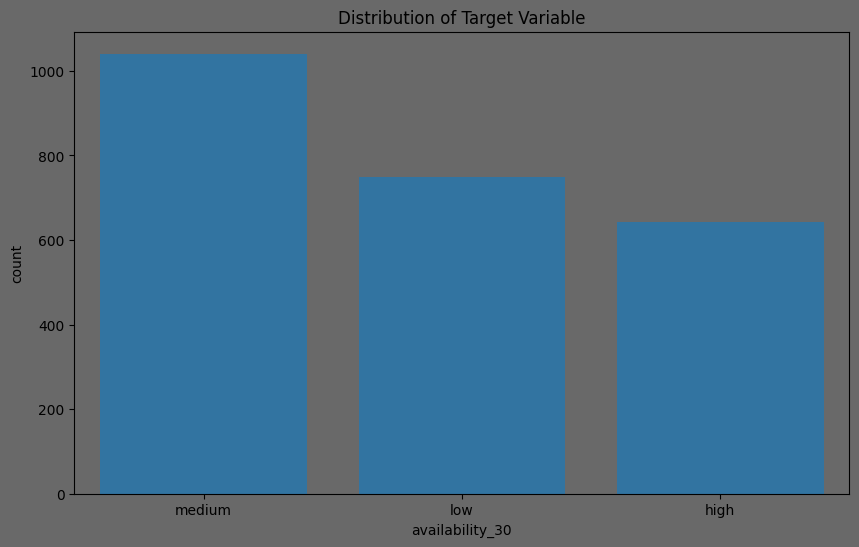


Target Variable Distribution:
availability_30
medium    0.428043
low       0.307977
high      0.263980
Name: proportion, dtype: float64


In [790]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='availability_30')
plt.title('Distribution of Target Variable')
plt.show()

print("\nTarget Variable Distribution:")
print(df['availability_30'].value_counts(normalize=True))

### Summary Statistics

In [791]:
X.describe()

,Unnamed: 0,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,2432.00000,2.432000e+03,2.432000e+03,2.432000e+03,2432.000000,2432.000000,0.0,2432.000000,2432.000000,2432.000000,2381.000000,2422.000000,2381.000000,2432.000000,2432.000000,2432.000000,2432.000000,2432.000000,2432.000000,2432.000000,2432.000000,0.0,2432.000000,2432.000000,2432.000000,2432.000000,2432.000000,2432.000000,2155.000000,2153.000000,2153.000000,2153.000000,2153.000000,2153.000000,2153.000000,2432.000000,2432.000000,2432.000000,2432.000000,2155.000000
mean,1215.50000,6.246186e+17,2.024063e+13,2.400893e+08,50.906250,77.680921,NaN,39.983140,-82.990719,5.077303,1.559849,2.080925,2.607728,8.162418,535.388980,7.396382,9.533306,705.155016,799.062089,8.790748,769.715461,NaN,31.865954,53.651316,214.777549,57.370477,18.977385,1.909951,4.784455,4.827863,4.772861,4.880831,4.888565,4.715007,4.734468,12.245066,10.885691,1.046875,0.029194,2.304255
std,702.20225,4.388163e+17,1.074440e+00,1.793149e+08,272.315221,432.223571,NaN,0.040408,0.040922,3.271071,0.854111,1.275729,2.167911,15.776499,425.893097,13.743820,16.736412,459.749460,424.199315,15.045330,423.490138,NaN,18.976184,26.985944,111.235636,93.922623,24.712629,2.988066,0.339578,0.299635,0.361425,0.244351,0.263292,0.404743,0.377707,16.840847,17.017355,2.915981,0.266710,2.012172
min,0.00000,9.067600e+04,2.024063e+13,7.876100e+04,1.000000,1.000000,NaN,39.833805,-83.174140,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,1.000000,1.000000,3.000000,1.000000,3.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.020000
25%,607.75000,5.186807e+07,2.024063e+13,7.728490e+07,2.000000,3.000000,NaN,39.955539,-83.006772,2.000000,1.000000,1.000000,1.000000,1.000000,200.000000,1.000000,2.000000,365.000000,365.000000,1.200000,365.000000,NaN,18.000000,37.000000,129.000000,4.000000,2.000000,0.000000,4.730000,4.790000,4.710000,4.860000,4.890000,4.620000,4.680000,2.000000,1.000000,0.000000,0.000000,0.800000
50%,1215.50000,7.771135e+17,2.024063e+13,1.942811e+08,7.000000,8.000000,NaN,39.978000,-82.997925,4.000000,1.000000,2.000000,2.000000,2.000000,365.000000,2.000000,2.000000,1125.000000,1125.000000,2.000000,1125.000000,NaN,34.000000,59.000000,228.000000,20.000000,11.000000,1.000000,4.880000,4.920000,4.880000,4.950000,4.960000,4.840000,4.830000,5.000000,3.000000,0.000000,0.000000,1.840000
75%,1823.25000,9.890660e+17,2.024063e+13,4.318945e+08,22.000000,28.000000,NaN,39.997607,-82.973275,6.000000,2.000000,3.000000,3.000000,4.000000,1125.000000,3.000000,11.000000,1125.000000,1125.000000,10.000000,1125.000000,NaN,48.000000,75.000000,325.000000,70.000000,27.000000,3.000000,4.970000,5.000000,4.980000,5.000000,5.000000,4.960000,4.930000,15.000000,14.000000,0.000000,0.000000,3.275000
max,2431.00000,1.186348e+18,2.024063e+13,5.831004e+08,2868.000000,4216.000000,NaN,40.147290,-82.782440,16.000000,10.000000,12.000000,30.000000,365.000000,1125.000000,365.000000,365.000000,1125.000000,1125.000000,365.000000,1125.000000,NaN,60.000000,90.000000,365.000000,879.000000,510.000000,88.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,80.000000,80.000000,19.000000,3.000000,22.6

In [792]:
X.describe(include='object')

,listing_url,last_scraped,source,name,description,neighborhood_overview,picture_url,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,property_type,room_type,bathrooms_text,amenities,price,has_availability,calendar_last_scraped,first_review,last_review,license,instant_bookable
count,2432,2432,2432,2432,2412,1634,2432,2432,2432,2432,1992,1504,2322,2322,2365,2326,2432,2432,2193,2432,2432,2432,1634,2432,2432,2432,2431,2432,2376,2426,2432,2155,2155,2100,2432
unique,2432,1,2,2400,2090,1107,2396,886,654,800,88,448,4,32,53,2,852,852,148,4,2,2,1,27,35,4,24,2332,393,1,1,1055,316,1664,2
top,https://www.airbnb.com/rooms/90676,2024-06-26,city scrape,Chic 1BR near Childrens Hospital,Explore a variety of attractions within easy r...,"Located in the heart of the city, our listing ...",https://a0.muscache.com/pictures/miso/Hosting-...,https://www.airbnb.com/users/show/158439641,GH Hospitality,2017-11-12,"Columbus, OH",To serve guests with a quality experience thro...,within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/f8509...,https://a0.muscache.com/im/pictures/user/f8509...,South Columbus,"['email', 'phone']",t,t,Neighborhood highlights,Near North/University,Entire home,Entire home/apt,1 bath,"[""Fire extinguisher"", ""TV"", ""Wifi"", ""Building ...",$100.00,t,2024-06-26,2023-03-05,2024-06-23,Exempt,f
freq,1,2432,2382,8,17,20,7,80,80,80,1616,80,2088,1827,615,1260,80,80,310,1777,2381,2187,1634,774,963,2018,1176,17,66,2426,2432,17,305,58,1637


In [793]:
# Uncomment for all rows in results
# pd.set_option('display.max_rows', None)

categorical_columns = X.select_dtypes(include=['object', 'category']).columns
for col in categorical_columns:
    print(f"\nValue counts for {col}:")
    print(X[col].value_counts())

# Resets max_rows to default
# pd.set_option('display.max_rows', 60)


Value counts for listing_url:
listing_url
https://www.airbnb.com/rooms/90676                  1
https://www.airbnb.com/rooms/923880283490901188     1
https://www.airbnb.com/rooms/922412152677412443     1
https://www.airbnb.com/rooms/922418916415987738     1
https://www.airbnb.com/rooms/922762159799418019     1
                                                   ..
https://www.airbnb.com/rooms/579130318703653698     1
https://www.airbnb.com/rooms/579920153215435176     1
https://www.airbnb.com/rooms/580147427622115239     1
https://www.airbnb.com/rooms/581933877357049763     1
https://www.airbnb.com/rooms/1186348038466244922    1
Name: count, Length: 2432, dtype: int64

Value counts for last_scraped:
last_scraped
2024-06-26    2432
Name: count, dtype: int64

Value counts for source:
source
city scrape        2382
previous scrape      50
Name: count, dtype: int64

Value counts for name:
name
Chic 1BR near Childrens Hospital                     8
Luxury Studio Suite | Downtown Columbus   

picture_url:
There are multiple records with the same photo. May be duplicate listings, or fake listings using an existing photo?

In [794]:
# Columns that could be parsed for keywords that may give more insight
columns_to_parse = [
    'name',
    'description',
    'neighborhood_overview',
    'host_about',
    'amenities'
]

binary_categories = [
    'host_has_profile_pic',
    'host_identity_verified',
    'host_is_superhost',
    'has_availability',
    'instant_bookable'
]

nominal_categories = [
    'host_url',
    'host_location',
    'host_neighbourhood',
    'host_verifications',
    'neighbourhood_cleansed',
    'property_type',
    'room_type'
]

ordinal_categories = [
    'host_since',
    'host_response_time',
    'host_response_rate',
    'host_acceptance_rate',
    'price',
    'first_review',
    'last_review',
    'license'
]

# Removes all features that 
# are identifiers of a single row, 
# are the same for all rows, 
# or are offering the same information from another feature, (ie. host identifiers/ keeping host_url and removing host_name and host_thumbnail_url)
categorical_columns_to_remove = [
    'source',
    'listing_url',
    'last_scraped',
    'calendar_last_scraped',
    'host_name',
    'host_thumbnail_url',
    'picture_url',
    'neighbourhood',
    'host_picture_url',
    'bathrooms_text'
]

categorical_columns = [item for item in categorical_columns if item not in categorical_columns_to_remove]

In [795]:
pd.set_option('display.max_rows', None)
print(X.isnull().sum())
pd.set_option('display.max_rows', 60)

Unnamed: 0                                         0
id                                                 0
listing_url                                        0
scrape_id                                          0
last_scraped                                       0
source                                             0
name                                               0
description                                       20
neighborhood_overview                            798
picture_url                                        0
host_id                                            0
host_url                                           0
host_name                                          0
host_since                                         0
host_location                                    440
host_about                                       928
host_response_time                               110
host_response_rate                               110
host_acceptance_rate                          

A quick check on nulls shows we have some features that are entirely empty. I also notice some features have the same amount of missing values and I wonder if they are the same rows with missing values. Finally there is a range of non-zero amounts of missing values from as low as 20 to as many as the entire data set. We will handle all of the missing values in the Feature Engineering section.

### Data Distributions

The following graphs are to get an idea of the distribution of each feature, we can dig deeper into each if we see a distribution we want to examine closer. For now its to see the shapes of each graph.

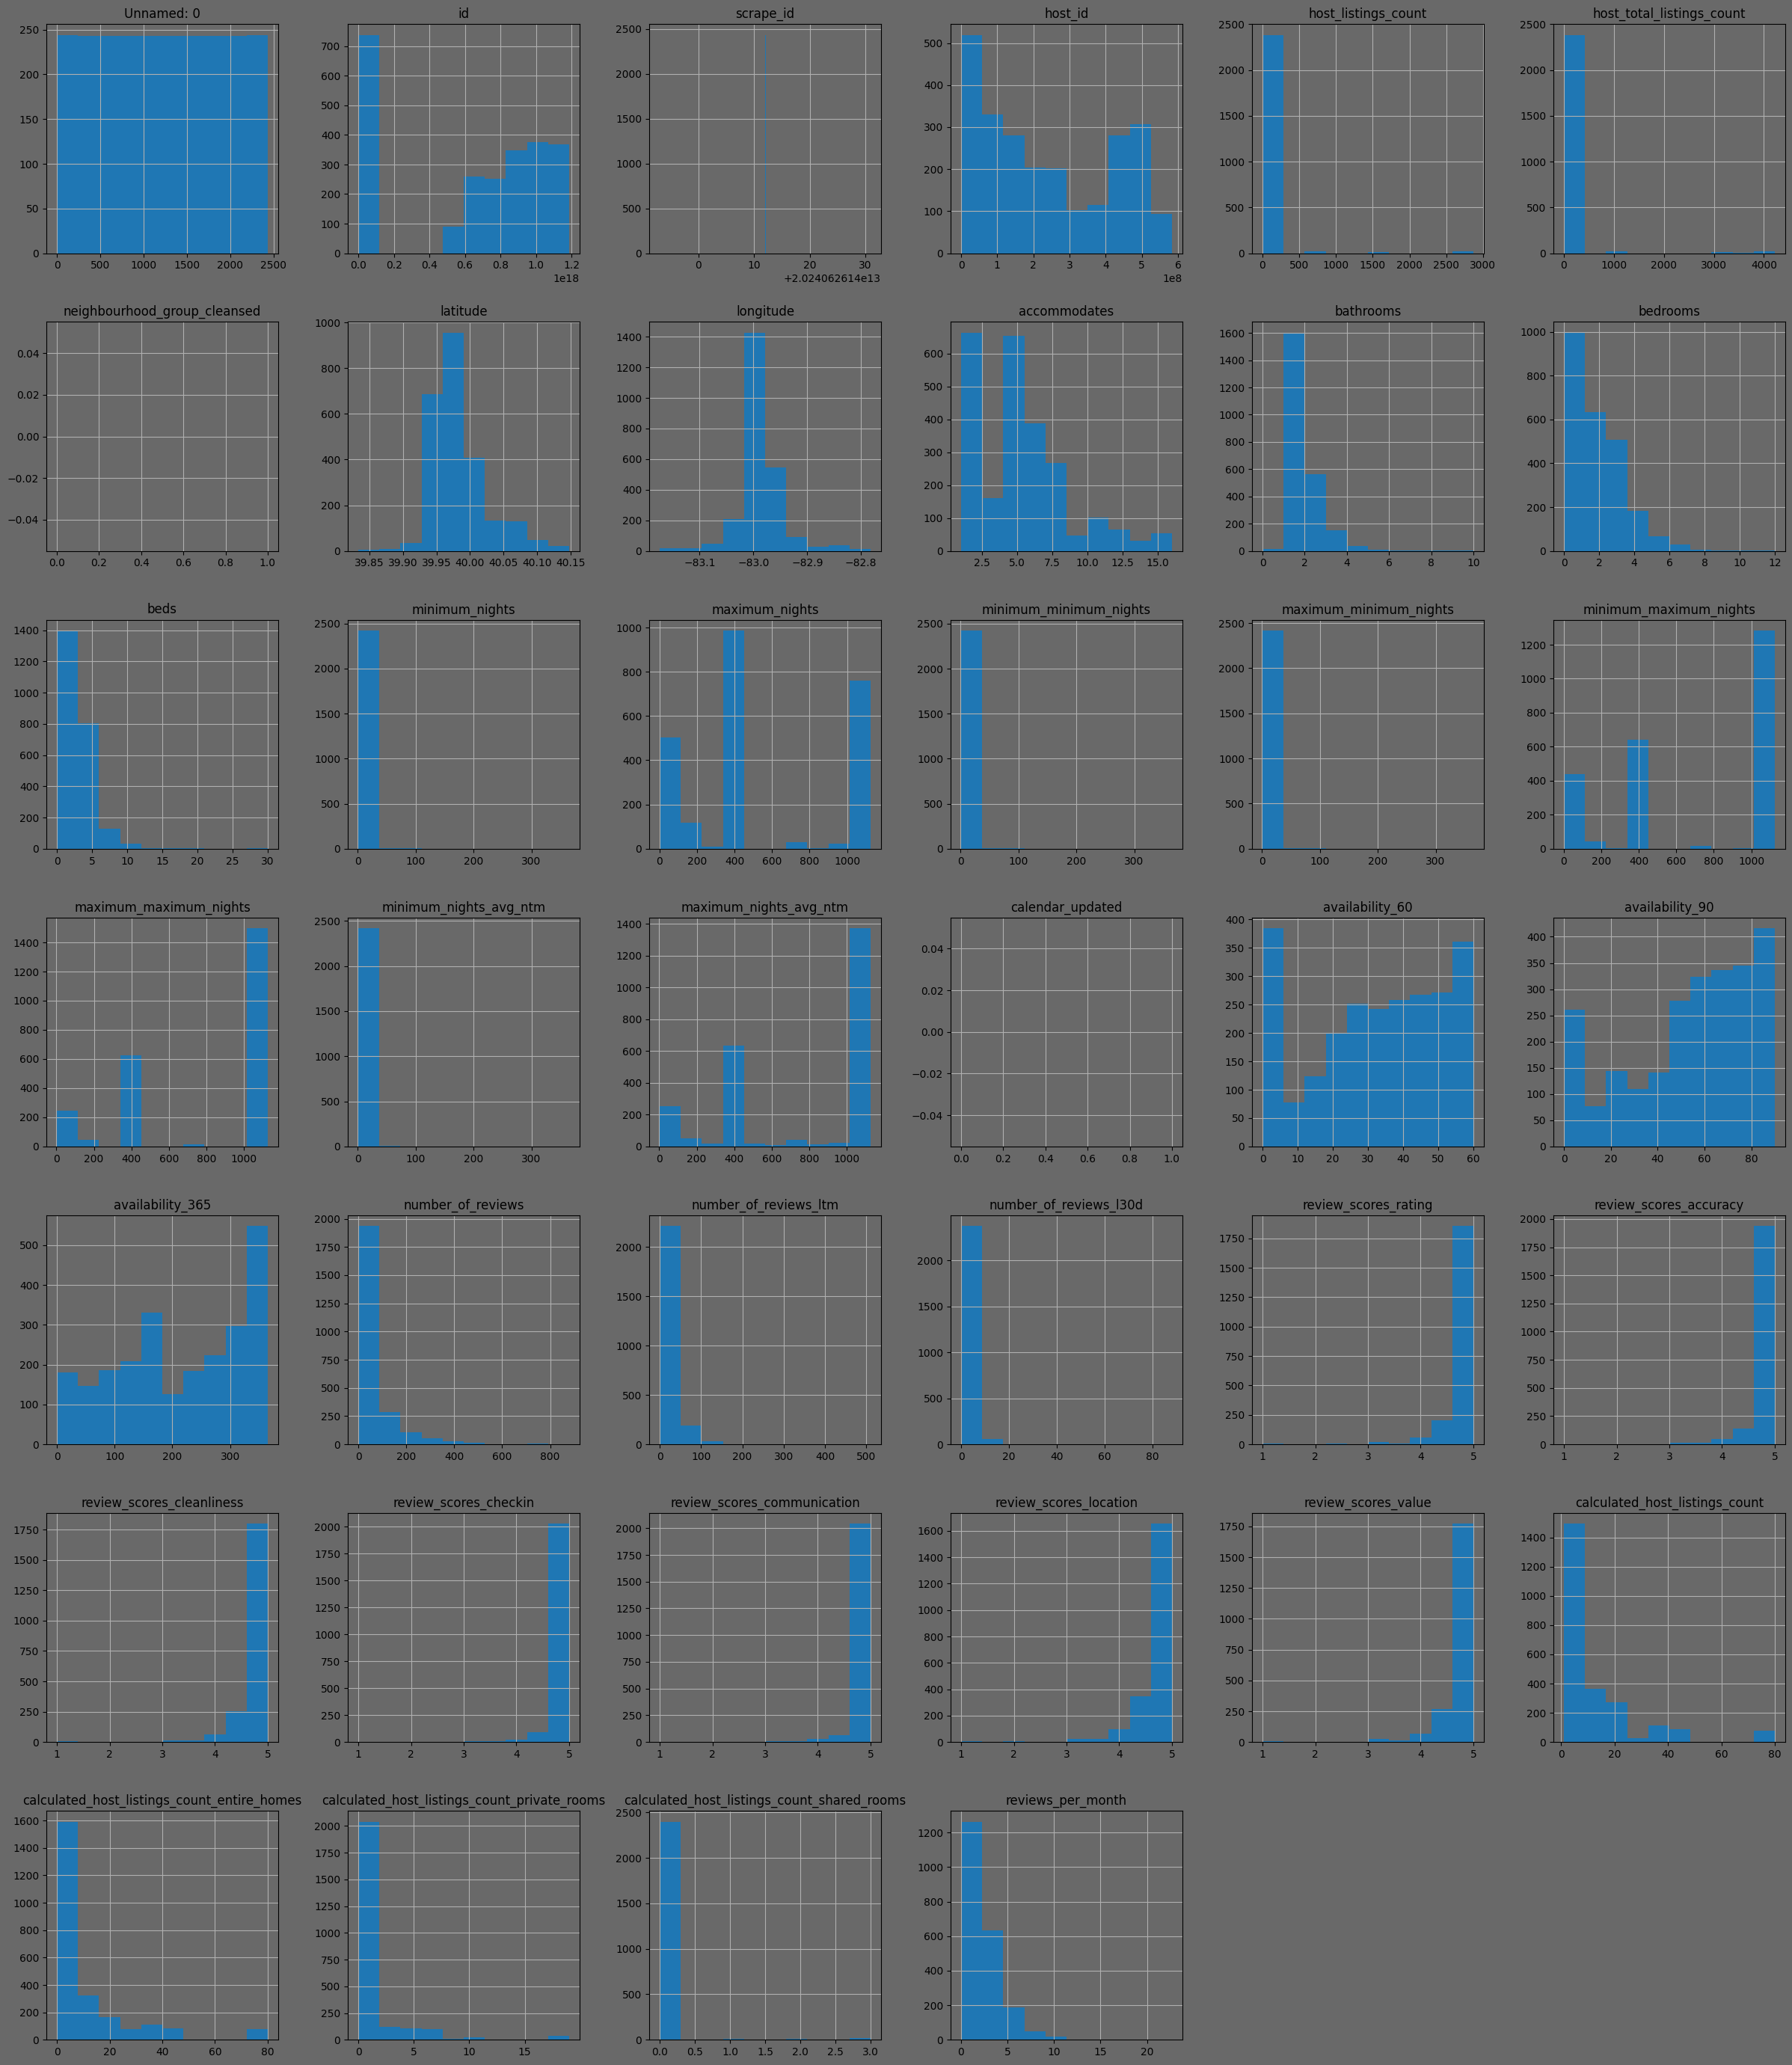

In [796]:
X.hist(figsize=(30, 35))
plt.show()

Time to handle our features that need parsed.

In [797]:
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = ''.join([char for char in text if char not in string.punctuation])
        words = text.split()
        stop_words = set(stopwords.words('english'))
        custom_stops = {'airbnb', 'house', 'home', 'apartment', 'room', 'property'}
        stop_words.update(custom_stops)
        words = [word for word in words if word not in stop_words]
        return ' '.join(words)
    else:
        return ''

Amenities are already cleaned and need handled differently then the rest. I will start there by placing each possible amenity into its own group and create dummy columns on if each listing has each category of amenity or not.

In [799]:
luxury_amenities = [
    'beach',
    'garage',
    'sauna',
    'jacuzzi',
    'pool',
    'hot tub',
    'private gym',
    'movie theater',
    'indoor fireplace',
    'private hot tub',
    'private pool',
    'waterfront',
    'beachfront',
    'valley view',
    'lake view',
    'city skyline view'
]

security_amenities = [
    'lockbox',
    'smart lock',
    'security cameras',
    'exterior security cameras',
    'window guards',
    'lock on bedroom door',
    'smoke alarm',
    'carbon monoxide alarm',
    'first aid kit',
    'fire extinguisher'
]

entertainment_amenities = [
    'speaker',
    'wifi',
    'sound system',
    'bluetooth sound system',
    'Hulu',
    'Prime Video',
    'Netflix',
    'TV',
    'HDTV',
    'Roku',
    'Disney+',
    'Chromecast',
    'Apple TV',
    'Piano',
    'pool table',
    'game console',
    'ping pong table',
    'bowling alley',
    'arcade games',
    'record player',
    'board games'
]

comfort_amenities = [
    'shampoo',
    'conditioner',
    'body soap',
    'coffee machine',
    'coffee maker',
    'parking',
    'dryer',
    'air conditioning',
    'heating',
    'ceiling fan',
    'portable fans',
    'central air conditioning',
    'radiant heating',
    'extra pillows and blankets',
    'hangers',
    'iron',
    'hair dryer',
    'bidet'
]

outdoor_amenities = [
    'patio',
    'grill',
    'bbq grill',
    'outdoor kitchen',
    'outdoor furniture',
    'outdoor dining area',
    'backyard',
    'fire pit',
    'outdoor shower',
    'sun loungers',
    'hammock'
]

fitness_amenities = [
    'gym',
    'exercise equipment',
    'treadmill',
    'elliptical',
    'stationary bike',
    'free weights',
    'yoga mat',
    'workout bench',
    'climbing wall',
    'batting cage'
]

family_amenities = [
    "children's books",
    "children's toys",
    'crib',
    'high chair',
    'changing table',
    'baby bath',
    'baby monitor',
    'baby safety gates',
    'outlet covers',
    'table corner guards',
    "children's dinnerware",
    "children's playroom"
]

work_amenities = [
    'workspace',
    'wifi',
    'ethernet connection',
    'desk'
]

cooking_amenities = [
    'oven',
    'stove',
    'coffee machine',
    'coffee maker',
    'fridge',
    'refrigerator',
    'freezer',
    'microwave',
    'dishwasher',
    'toaster',
    'blender',
    'rice maker',
    'bread maker',
    'hot water kettle',
    'wine glasses',
    'dishes and silverware',
    'cooking basics',
    'baking sheet',
    'trash compactor'
]

accessibility_amenities = [
    'elevator',
    'single level home',
    'step-free access',
    'wide doorway',
    'wide hallway'
]

services_amenities = [
    'housekeeping',
    'building staff',
    'host greets you',
    'self check-in',
    'luggage dropoff allowed',
    'long term stays allowed',
    'babysitter recommendations'
]

eco_friendly_amenities = [
    'ev charger',
    'organic products',
    'vegan products',
    'cruelty-free products'
]

categories = {
    'has_luxury': luxury_amenities,
    'has_security': security_amenities,
    'has_entertainment': entertainment_amenities,
    'has_comfort': comfort_amenities,
    'has_outdoor': outdoor_amenities,
    'has_fitness': fitness_amenities,
    'has_family': family_amenities,
    'has_work': work_amenities,
    'has_cooking': cooking_amenities,
    'has_accessibility': accessibility_amenities,
    'has_services': services_amenities,
    'has_eco': eco_friendly_amenities
}

for column_name, amenity_list in categories.items():
    X[column_name] = X['amenities'].apply(
        lambda x: any(keyword.lower() in item.lower() 
                     for item in x 
                     for keyword in amenity_list)
    ).astype(int)


X['amenities_count'] = X['amenities'].apply(len)
X = X.drop('amenities', axis=1)

columns_to_parse.remove('amenities')

In [800]:
for col in columns_to_parse:
    X[col] = X[col].apply(clean_text)

In [801]:
text_features = {}
for col in columns_to_parse:
    X[col] = X[col].apply(clean_text)
    
    vectorizer = TfidfVectorizer(
        max_features=20,
        min_df=0.01,
        max_df=0.95,
        ngram_range=(1, 2)
    )
    
    tfidf_matrix = vectorizer.fit_transform(X[col])
    feature_names = [f"{col}_{name}" for name in vectorizer.get_feature_names_out()]

    tfidf_df = pd.DataFrame(
        tfidf_matrix.toarray(),
        columns=feature_names
    )

    text_features[col] = tfidf_df

for col, features_df in text_features.items():
    X = pd.concat([X, features_df], axis=1)
    X.drop(col, axis=1, inplace=True)


text_feature_cols = [col for col in X.columns if any(prefix in col for prefix in ['name_', 'description_', 'neighborhood_overview_', 'host_about_'])]
correlations = pd.DataFrame({
    'feature': text_feature_cols,
    'correlation': [X[col].corr(y_numeric) for col in text_feature_cols]
})

correlations['abs_correlation'] = correlations['correlation'].abs()
correlations_sorted = correlations.sort_values('abs_correlation', ascending=False)


correlation_threshold = 0.07 
important_text_features = correlations_sorted[
    correlations_sorted['abs_correlation'] >= correlation_threshold
]['feature'].tolist()


text_features_to_drop = [col for col in text_feature_cols if col not in important_text_features]
X = X.drop(columns=text_features_to_drop)

print(f"Kept {len(important_text_features)} text features out of {len(text_feature_cols)} total")
print("\nMost important text features and their correlations:")
print(correlations_sorted[correlations_sorted['feature'].isin(important_text_features)])
    

Kept 4 text features out of 80 total

Most important text features and their correlations:
                     feature  correlation  abs_correlation
18               name_studio     0.114025         0.114025
64     host_about_experience     0.087319         0.087319
60           host_about_city     0.085907         0.085907
42  neighborhood_overview_br     0.077399         0.077399


These numbers are quite low and I'm not sure they offer much for predictions.

In [802]:
def plot_binary_pie(df, column):
    values = df[column].value_counts(dropna=False)
    
    plt.figure(figsize=(10, 6))
    plt.pie(values, labels=values.index, autopct='%1.1f%%')
    plt.title(f'Distribution of {column}')
    plt.show()

def plot_nominal_pie(df, column):
    values = df[column].value_counts(dropna=False)
    
    if len(values) > 10:
        other_sum = values[10:].sum()
        values = values[:10]
        values['Others'] = other_sum
    
    plt.figure(figsize=(12, 8))
    plt.pie(values, labels=values.index, autopct='%1.1f%%')
    plt.title(f'Distribution of {column}')
    plt.show()


def clean_price(value):
    if pd.isna(value) or value == 'N/A':
        return np.nan
    if isinstance(value, str):
        return float(value.strip('$').replace(',', ''))
    return value


def clean_percentage(value):
    if pd.isna(value) or value == 'N/A':
        return np.nan
    if isinstance(value, str):
        return float(value.strip('%'))
    return value

X['host_response_rate'] = X['host_response_rate'].apply(clean_percentage)
X['host_acceptance_rate'] = X['host_acceptance_rate'].apply(clean_percentage)
X['price'] = X['price'].apply(clean_price)


def plot_ordinal_bar(df, column):
    plt.figure(figsize=(12, 6))
    
    if df[column].dtype == 'datetime64[ns]':
        year_counts = df[column].dt.year.value_counts().sort_index()
        sns.barplot(x=year_counts.index, y=year_counts.values)
    else:
        if column == 'host_response_time':
            order = ['within an hour', 'within a few hours', 'within a day', 'a few days or more']
            sns.countplot(data=df, x=column, order=order)
        elif column in ['host_response_rate', 'host_acceptance_rate']:
            bins = np.linspace(0, 100, 11)
            df[f'{column}_binned'] = pd.cut(df[column], bins=bins)
            sns.countplot(data=df, x=f'{column}_binned')
            plt.xlabel(f'{column} (%)')
        elif column == 'price':
            bins = [0, 50, 100, 200, 500, 1000, float('inf')]
            labels = ['0-50', '51-100', '101-200', '201-500', '501-1000', '1000+']
            df['price_binned'] = pd.cut(df[column], bins=bins, labels=labels)
            sns.countplot(data=df, x='price_binned')
            plt.xlabel('Price ($)')
        else:
            sns.countplot(data=df, x=column)
    
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Binary Categories:

Distribution for host_has_profile_pic:


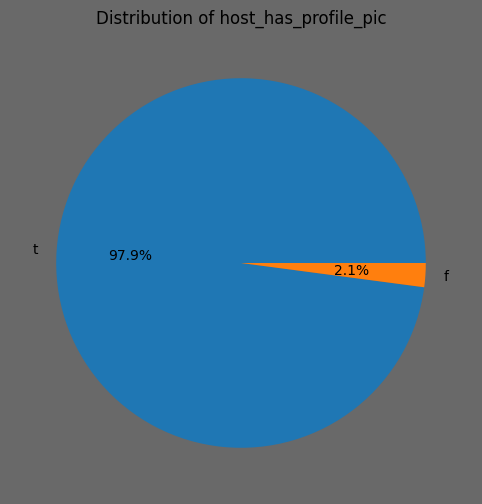


Distribution for host_identity_verified:


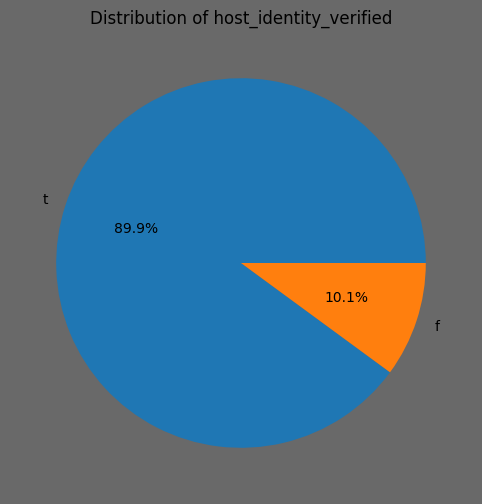


Distribution for host_is_superhost:


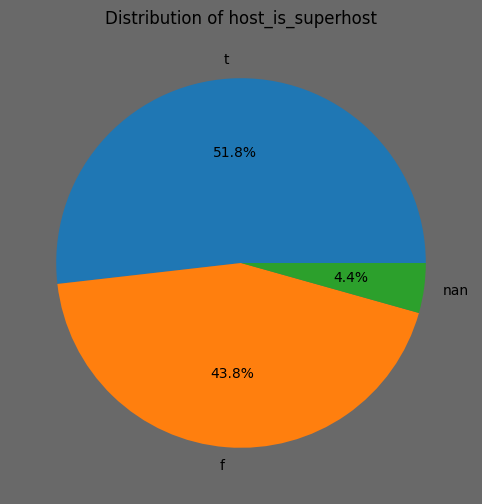


Distribution for has_availability:


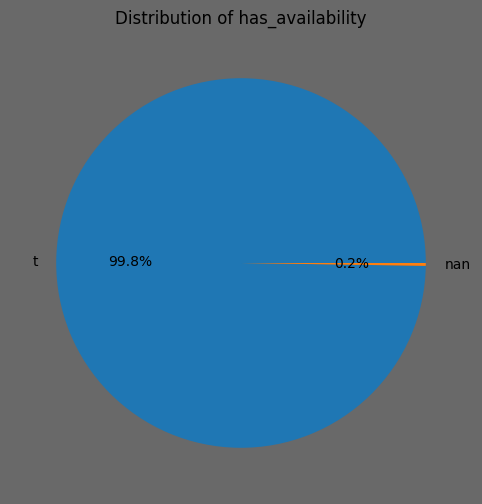


Distribution for instant_bookable:


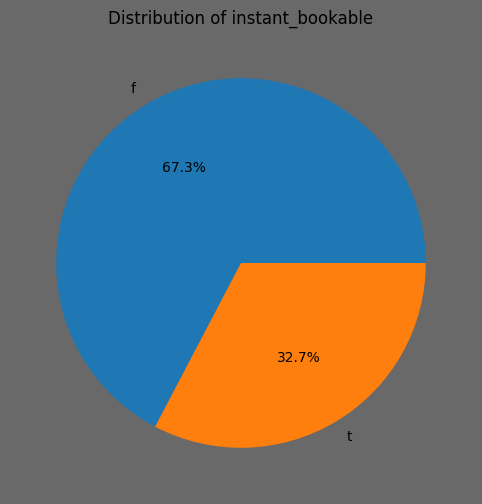


Nominal Categories:

Distribution for host_url:


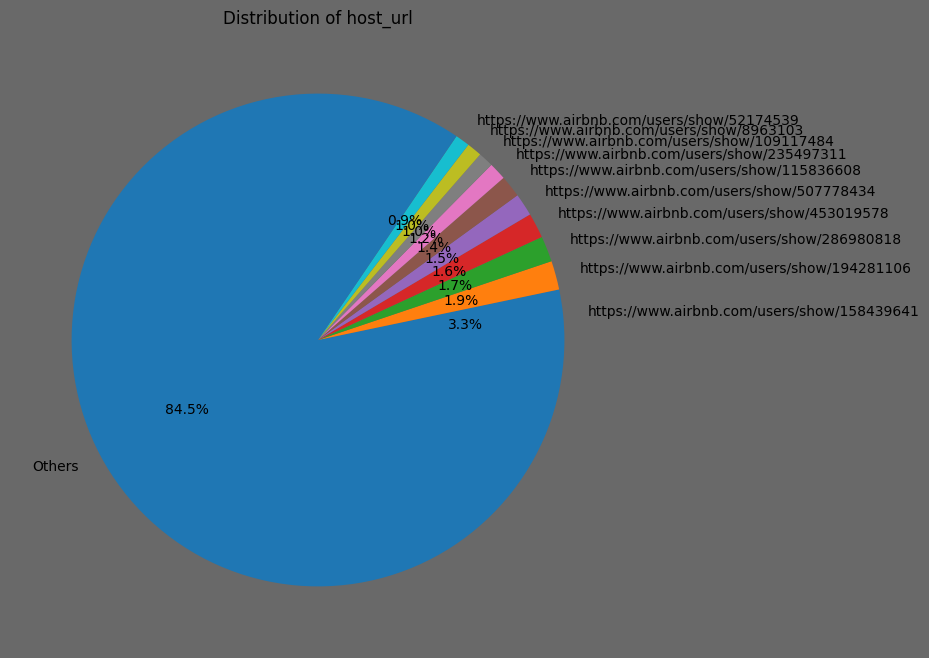


Distribution for host_location:


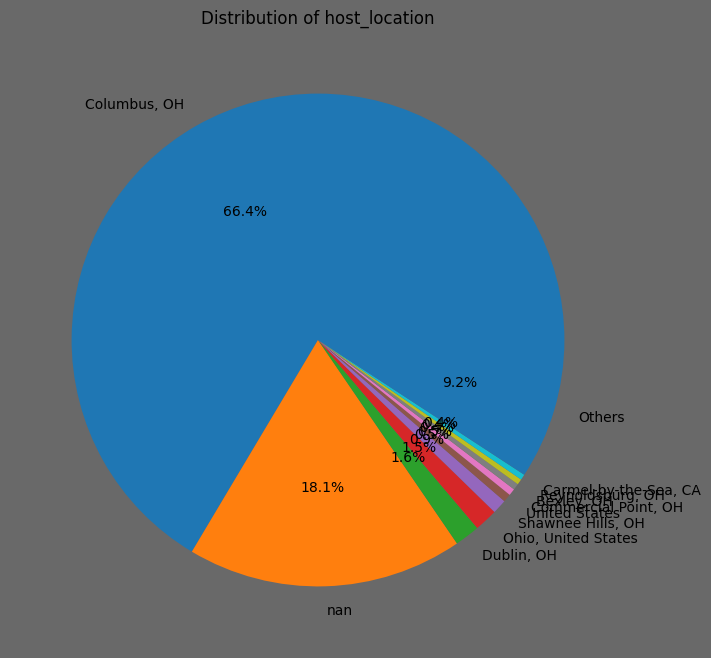


Distribution for host_neighbourhood:


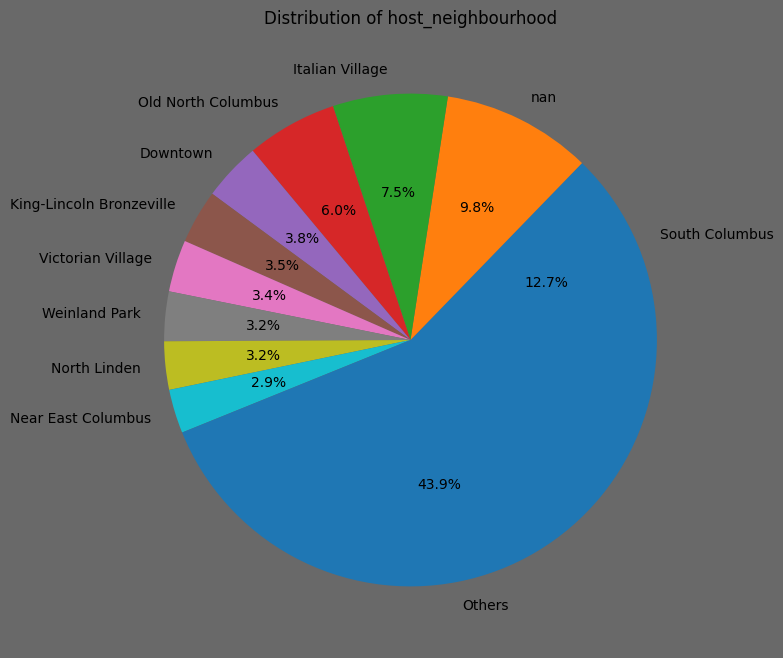


Distribution for host_verifications:


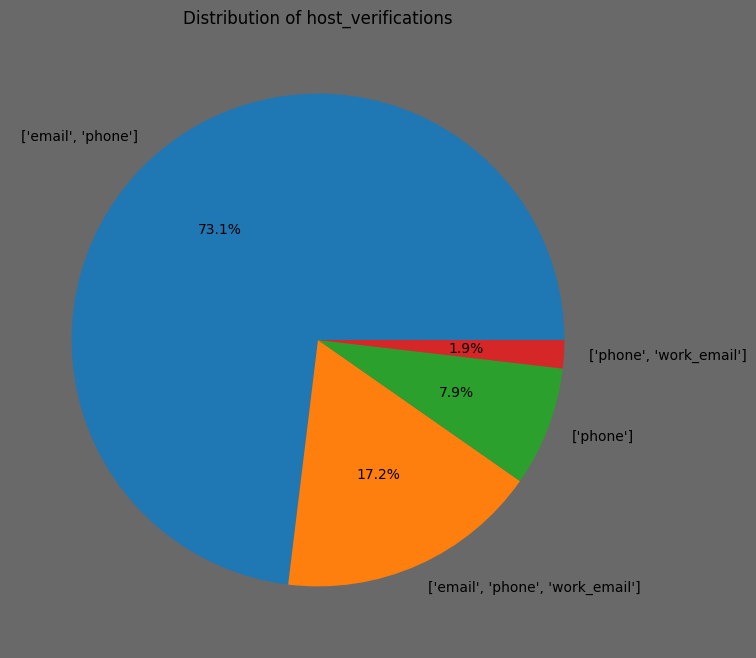


Distribution for neighbourhood_cleansed:


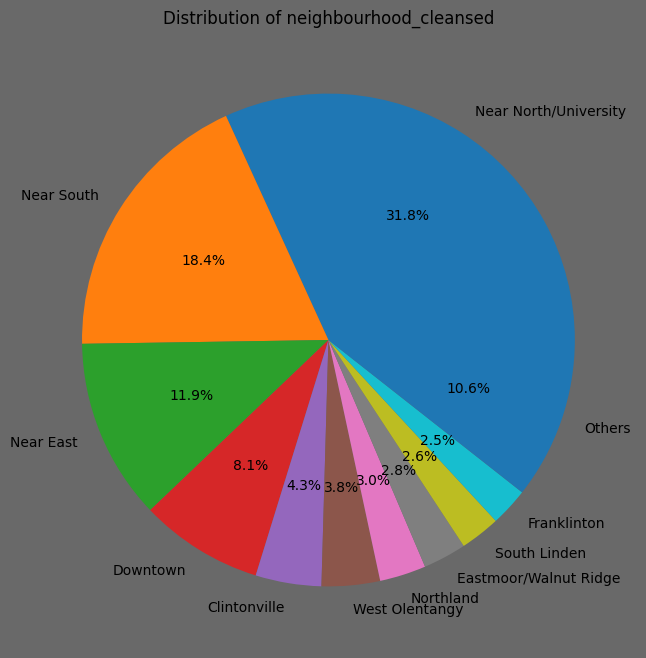


Distribution for property_type:


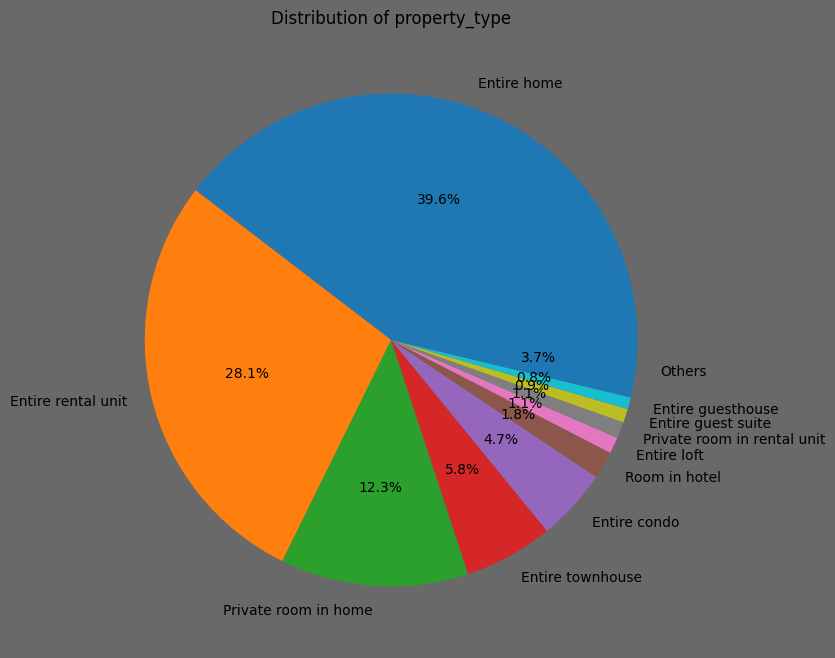


Distribution for room_type:


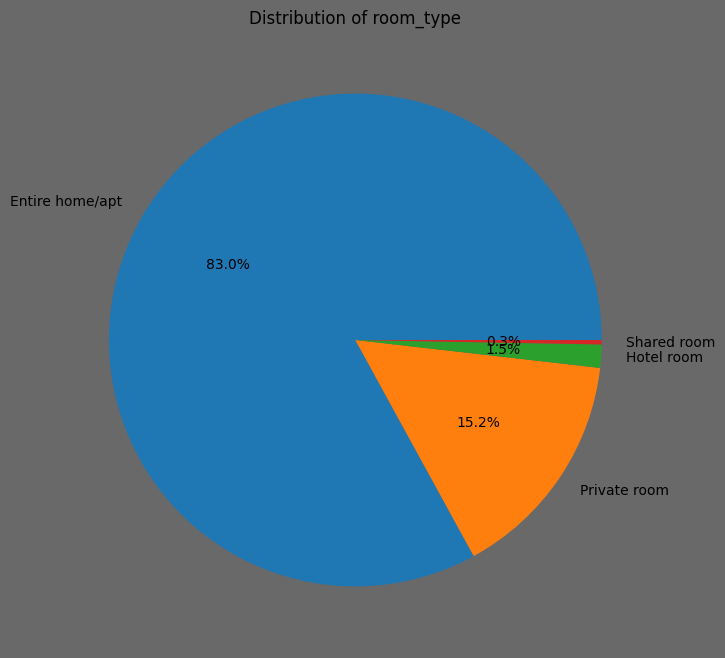


Ordinal Categories:

Distribution for host_since:


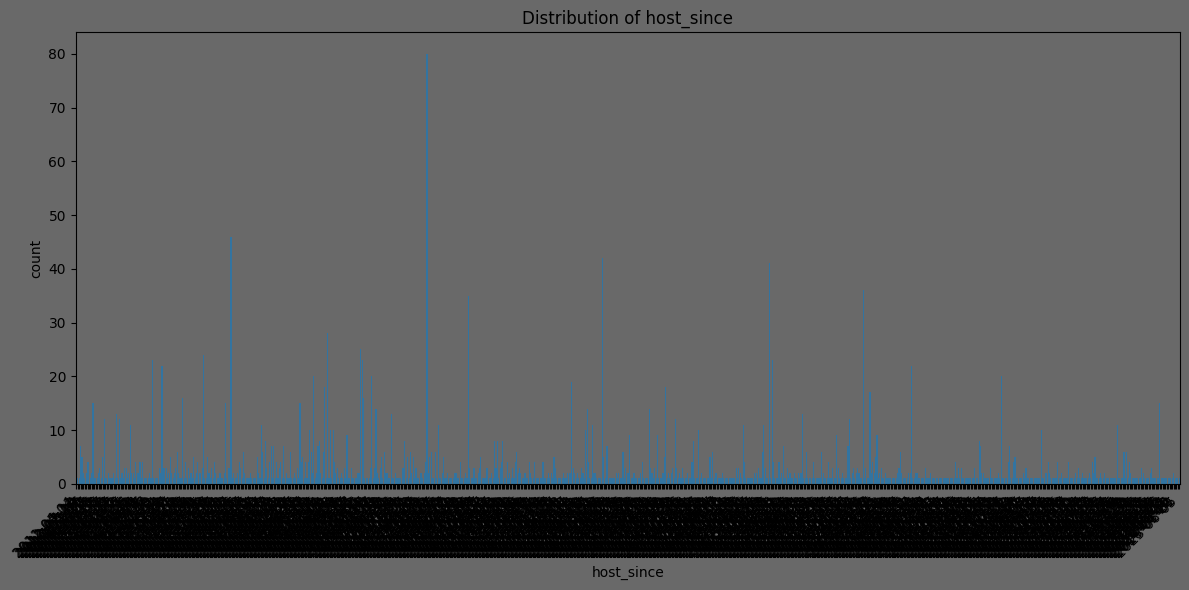


Distribution for host_response_time:


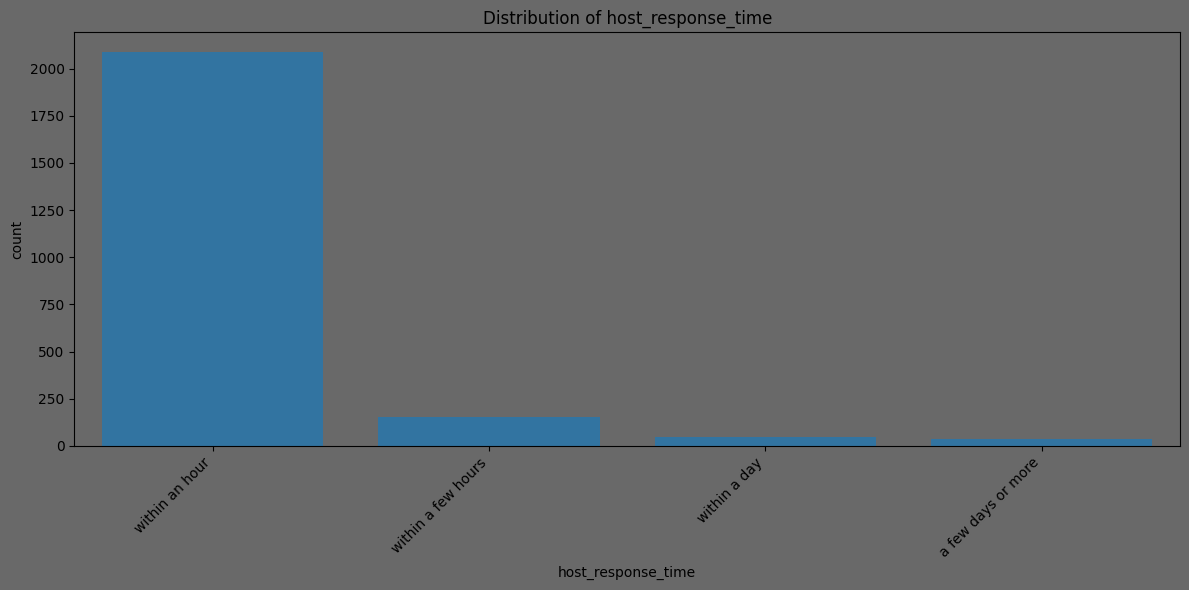


Distribution for host_response_rate:


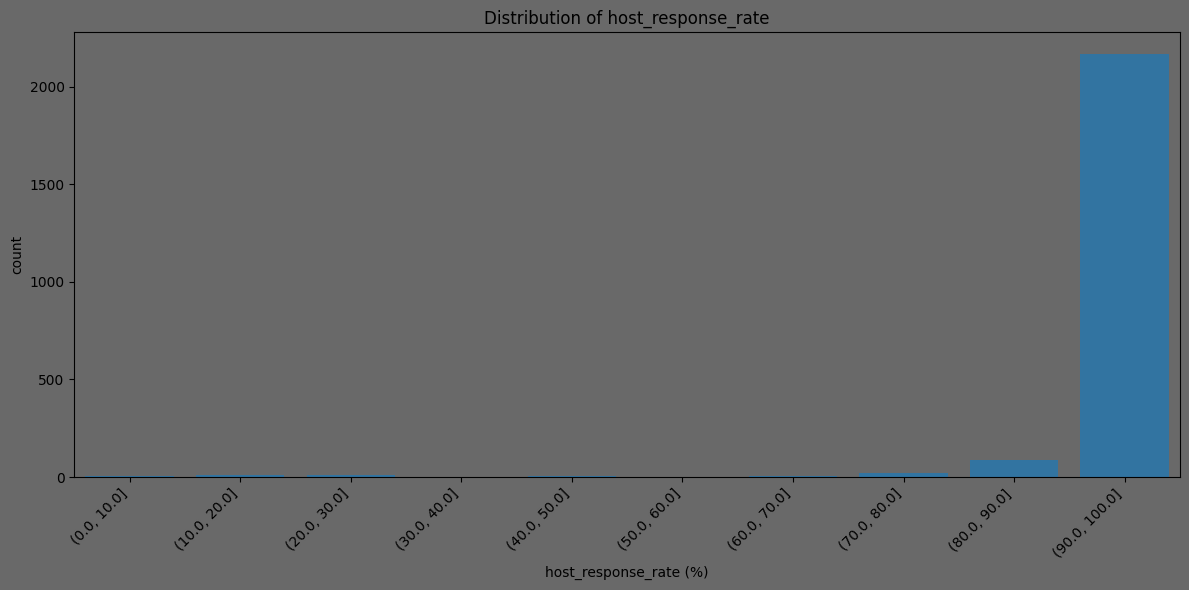


Distribution for host_acceptance_rate:


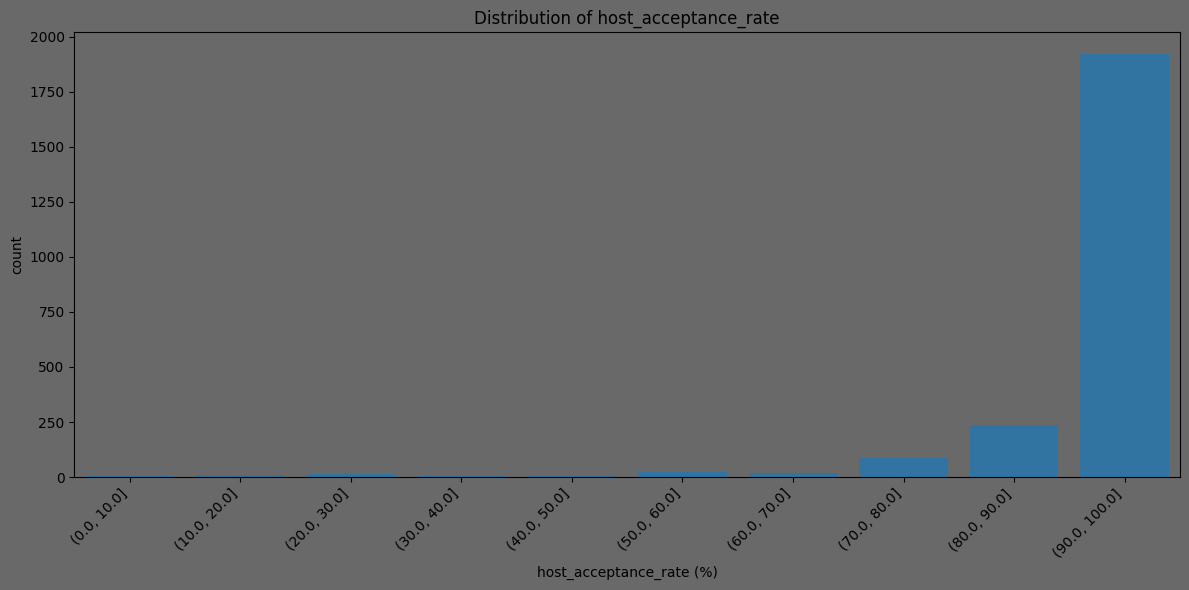


Distribution for price:


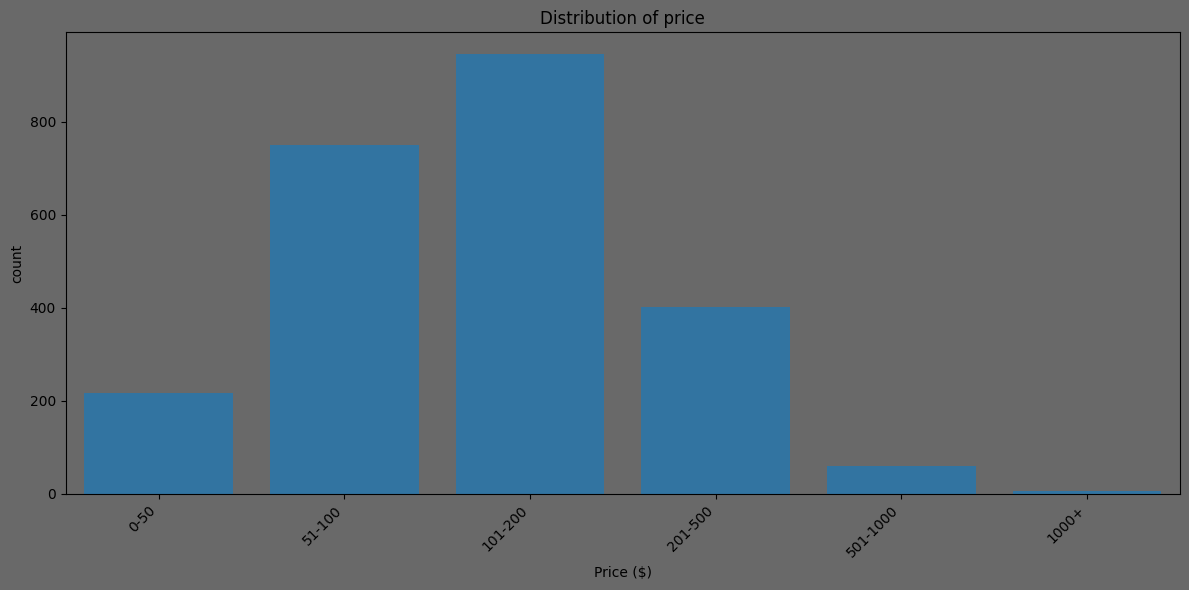


Distribution for first_review:


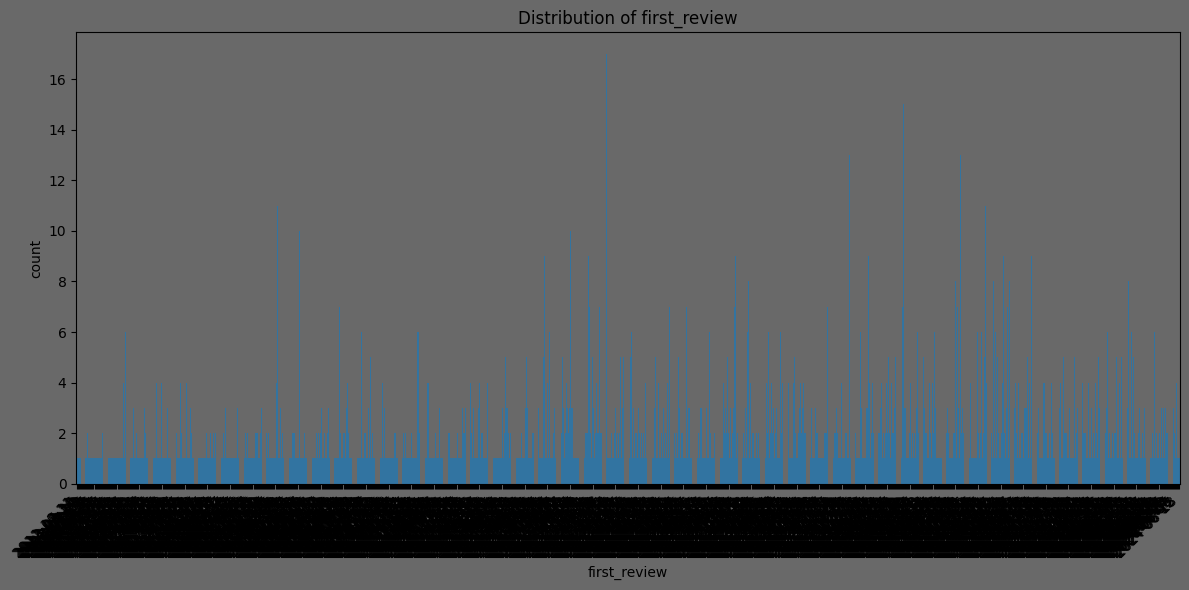


Distribution for last_review:


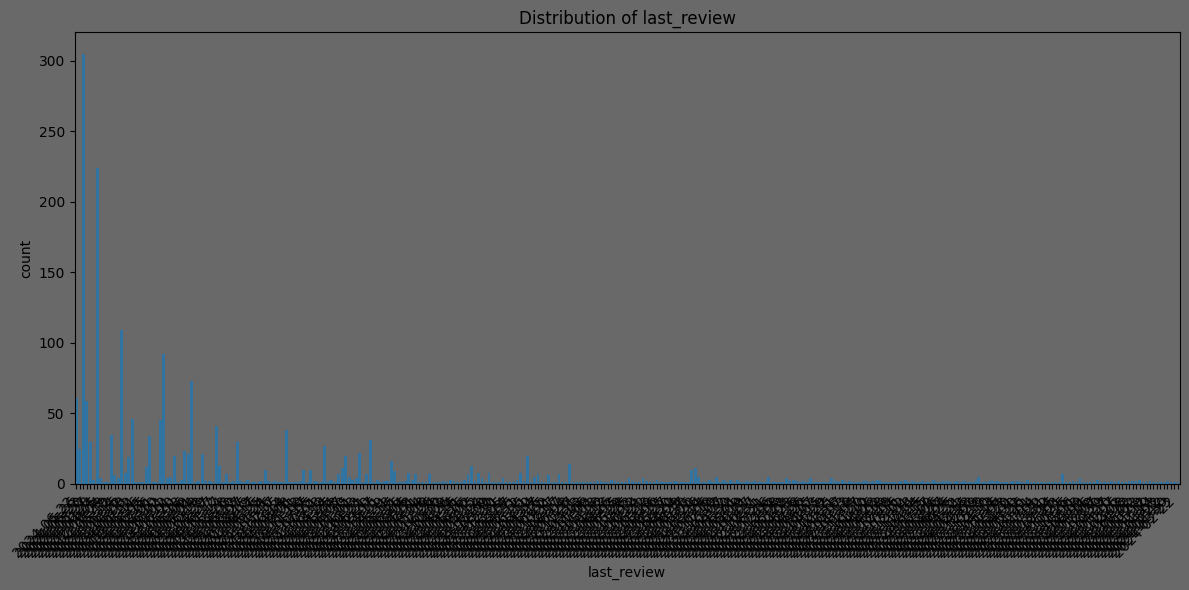


Distribution for license:


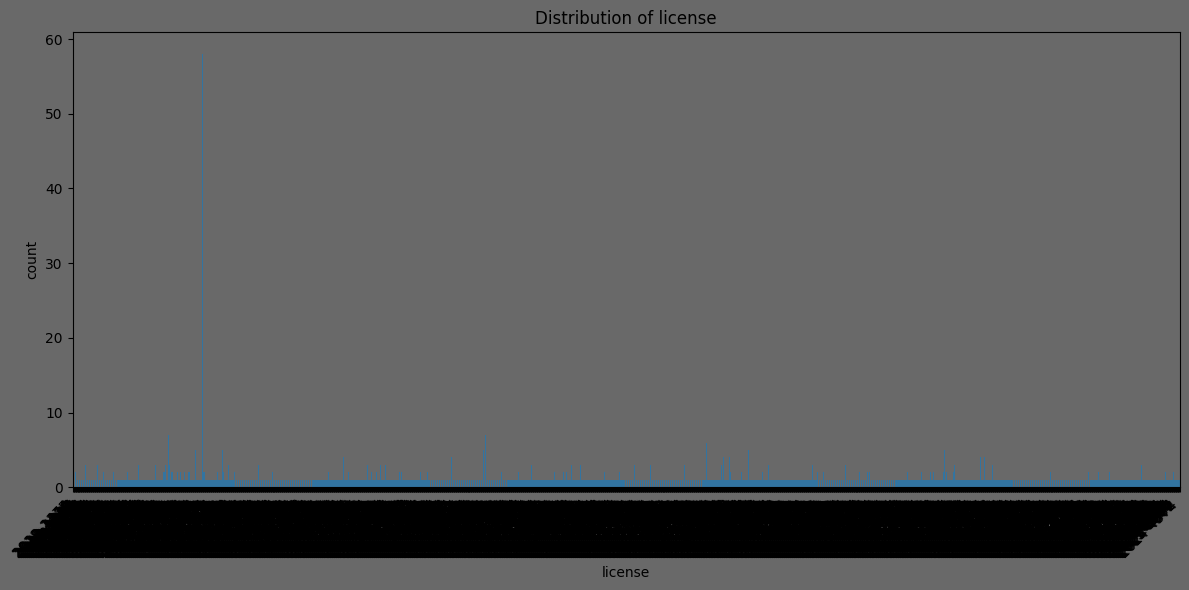

In [803]:
print("Binary Categories:")
for col in binary_categories:
    if col in X.columns:
        print(f"\nDistribution for {col}:")
        plot_binary_pie(X, col)

print("\nNominal Categories:")
for col in nominal_categories:
    if col in X.columns:
        print(f"\nDistribution for {col}:")
        plot_nominal_pie(X, col)

print("\nOrdinal Categories:")
for col in ordinal_categories:
    if col in X.columns:
        print(f"\nDistribution for {col}:")
        plot_ordinal_bar(X, col)

### Correlation Analysis

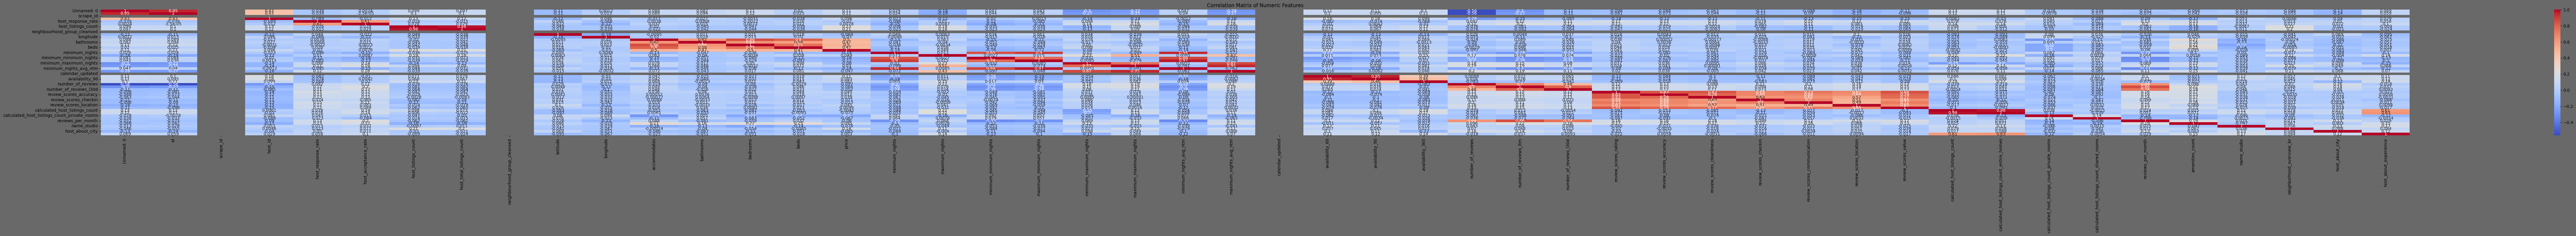

In [804]:
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = X[numeric_columns].corr()

plt.figure(figsize=(100, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

Correlations between each feature

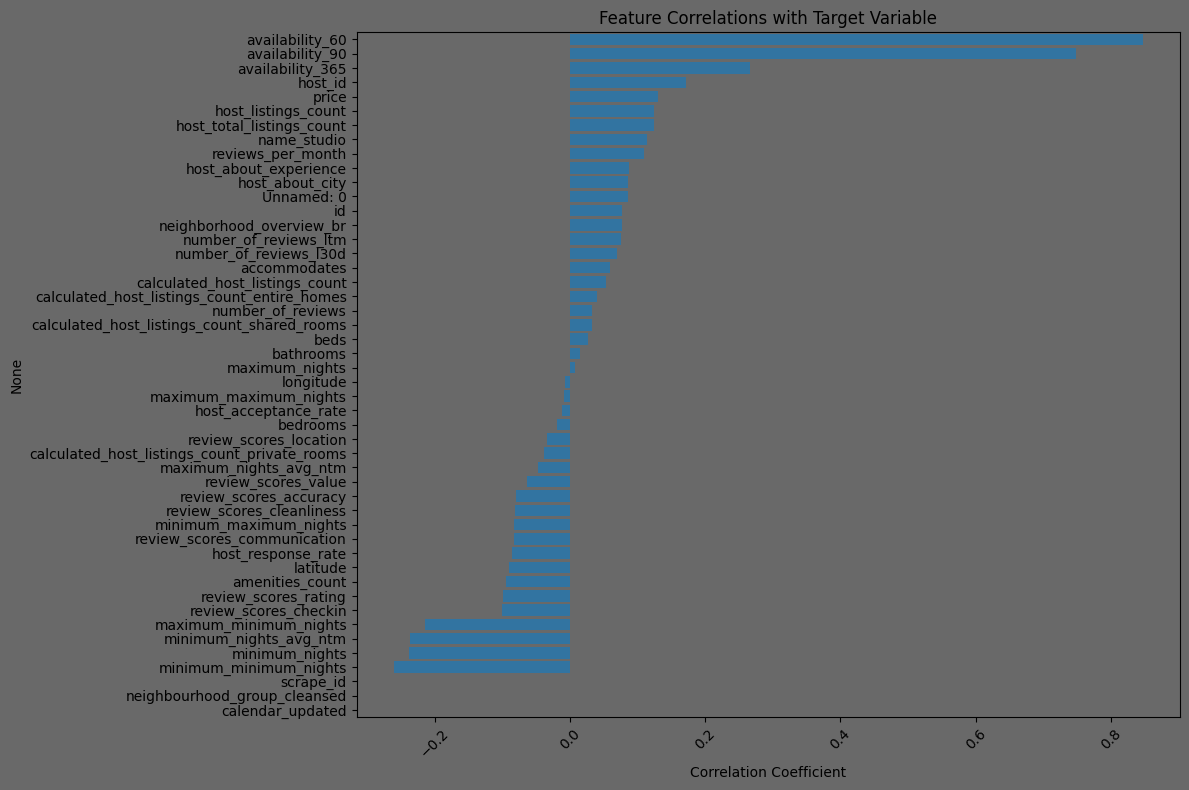


Correlations with target variable:
availability_60                                 0.846843
availability_90                                 0.748235
availability_365                                0.266661
host_id                                         0.171834
price                                           0.130297
host_listings_count                             0.124484
host_total_listings_count                       0.123894
name_studio                                     0.114025
reviews_per_month                               0.109678
host_about_experience                           0.087319
host_about_city                                 0.085907
Unnamed: 0                                      0.085656
id                                              0.077516
neighborhood_overview_br                        0.077399
number_of_reviews_ltm                           0.075575
number_of_reviews_l30d                          0.069341
accommodates                                    0.05

In [805]:
X_with_target = X[numeric_columns].copy()
X_with_target['target'] = y_numeric

target_correlations = X_with_target.corr()['target'].sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=target_correlations.values[1:], y=target_correlations.index[1:])
plt.title('Feature Correlations with Target Variable')
plt.xlabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nCorrelations with target variable:")
print(target_correlations[1:])

In [806]:
def chi_square_test(df, categorical_col, target_col='availability_30'):
    contingency = pd.crosstab(df[categorical_col], df[target_col])
    chi2, p_value, _, _ = chi2_contingency(contingency)
    return categorical_col, chi2, p_value

categorical_results = []
for col in categorical_columns:
    result = chi_square_test(df, col)
    categorical_results.append(result)

categorical_results.sort(key=lambda x: x[1], reverse=True)
print("\nChi-square test results (sorted by chi-square value):")
for col, chi2, p_value in categorical_results:
    print(f"{col}: chi2={chi2:.2f}, p-value={p_value:.4f}")


Chi-square test results (sorted by chi-square value):
name: chi2=4823.63, p-value=0.3944
amenities: chi2=4752.26, p-value=0.1747
description: chi2=4439.11, p-value=0.0025
license: chi2=3598.67, p-value=0.0005
host_url: chi2=2688.48, p-value=0.0000
neighborhood_overview: chi2=2584.63, p-value=0.0000
host_since: chi2=2474.11, p-value=0.0000
first_review: chi2=2141.65, p-value=0.2996
host_about: chi2=1445.05, p-value=0.0000
last_review: chi2=987.25, p-value=0.0000
price: chi2=965.41, p-value=0.0000
host_neighbourhood: chi2=657.26, p-value=0.0000
host_acceptance_rate: chi2=288.95, p-value=0.0000
host_location: chi2=259.26, p-value=0.0000
host_response_rate: chi2=247.89, p-value=0.0000
property_type: chi2=235.93, p-value=0.0000
neighbourhood_cleansed: chi2=166.40, p-value=0.0000
room_type: chi2=131.39, p-value=0.0000
host_is_superhost: chi2=89.15, p-value=0.0000
host_response_time: chi2=80.75, p-value=0.0000
host_verifications: chi2=57.70, p-value=0.0000
instant_bookable: chi2=54.45, p-val

## 2. Feature engineering

- Handle missing values
- Create or transform features that might improve model performance
- Examples might include creating interaction terms, encoding categorical variables, feature scaling

### Handle missing values

In [807]:
missing_percentages = (X.isnull().sum() / len(X)) * 100
print("Missing value percentages:")
print(missing_percentages[missing_percentages > 0].sort_values(ascending=False))

Missing value percentages:
calendar_updated                100.000000
neighbourhood_group_cleansed    100.000000
neighbourhood                    32.812500
host_location                    18.092105
license                          13.651316
review_scores_communication      11.472039
review_scores_checkin            11.472039
review_scores_cleanliness        11.472039
review_scores_accuracy           11.472039
review_scores_location           11.472039
review_scores_value              11.472039
first_review                     11.389803
reviews_per_month                11.389803
review_scores_rating             11.389803
last_review                      11.389803
host_neighbourhood                9.827303
host_response_rate_binned         5.139803
host_response_time                4.523026
host_response_rate                4.523026
host_is_superhost                 4.358553
host_acceptance_rate_binned       4.194079
host_acceptance_rate              2.754934
price_binned               

In [808]:
columns_to_drop = missing_percentages[missing_percentages > 50].index
X = X.drop(columns=columns_to_drop)
print(f"\nDropped {len(columns_to_drop)} columns with >50% missing values")


Dropped 2 columns with >50% missing values


To quickly handle missing values I am going to impute numerical values with the median and categorical values with the mode. If any of these show to have a large feature importance I will look to be more precise with their imputation.

In [809]:
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
X[numerical_columns] = X[numerical_columns].fillna(X[numerical_columns].median())

categorical_columns = X.select_dtypes(include=['object']).columns
for col in categorical_columns:
    mode_value = X[col].mode().iloc[0]
    X[col] = X[col].fillna(mode_value)

binned_columns = ['host_response_rate_binned', 'host_acceptance_rate_binned', 'price_binned']
for col in binned_columns:
    mode_value = X[col].mode().iloc[0]
    X[col] = X[col].fillna(mode_value)

print("\nMissing values after imputation:")
print(X.isnull().sum()[X.isnull().sum() > 0])


Missing values after imputation:
Series([], dtype: int64)


### Feature transfomations

In [810]:
date_columns = ['host_since', 'first_review', 'last_review']
for col in date_columns:
    if col in X.columns:
        X[col] = pd.to_datetime(X[col])
        X[f'{col}_year'] = X[col].dt.year
        X[f'{col}_month'] = X[col].dt.month
        X = X.drop(columns=col) 

In [811]:
nominal_to_encode = [col for col in nominal_categories if col in X.columns]
max_categories = 10 
for col in nominal_to_encode:
    top_categories = X[col].value_counts().nlargest(max_categories).index
    X[col] = X[col].where(X[col].isin(top_categories), 'Other')
X = pd.get_dummies(X, columns=nominal_to_encode, drop_first=True)


In [812]:
response_time_order = {
    'within an hour': 4,
    'within a few hours': 3,
    'within a day': 2,
    'a few days or more': 1
}
if 'host_response_time' in X.columns:
    X['host_response_time'] = X['host_response_time'].map(response_time_order)

In [813]:
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

print("\nFeature engineering complete!")
print(f"Final dataset shape: {X.shape}")


Feature engineering complete!
Final dataset shape: (2432, 140)


## 3. Model training

- Experiment with at least 3 different machine learning algorithms
- Implement hyperparameter tuning using techniques like Grid Search or Random Search
- Perform feature selection to identify relevant features
- Use cross-validation to assess model performance

### Feature selection

In [814]:
columns_to_drop = [
    'host_response_rate_bin', 
    'host_acceptance_rate_bin', 
    'price_bin',
    'host_url',
    'Unnamed: 0',
    'id',
    'scrape_id',
    'host_id',
    'listing_url',
    'calendar_last_scraped', 
    'last_scraped'
]

X = X.drop(columns=[col for col in columns_to_drop if col in X.columns])

text_columns = X.select_dtypes(include=['object']).columns

if len(text_columns) > 0:
    print("Removing remaining text columns:", text_columns)
    X = X.drop(columns=text_columns)

# Remove any interval/binned columns that were created for visualization
binned_columns = [col for col in X.columns if 'binned' in col]
X = X.drop(columns=binned_columns, errors='ignore')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Removing remaining text columns: Index(['source', 'picture_url', 'host_name', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood', 'bathrooms_text',
       'has_availability', 'license', 'instant_bookable'],
      dtype='object')


In [815]:
feat_selector = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold='mean'
)
feat_selector.fit(X_train, y_train)

selected_feat_mask = feat_selector.get_support()
selected_features = X_train.columns[selected_feat_mask].tolist()

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"Selected {len(selected_features)} features out of {X_train.shape[1]}")
for feature in selected_features:
    print(feature)


Selected 30 features out of 117
host_acceptance_rate
host_listings_count
host_total_listings_count
latitude
longitude
accommodates
beds
price
minimum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_nights_avg_ntm
availability_60
availability_90
availability_365
number_of_reviews
number_of_reviews_ltm
number_of_reviews_l30d
review_scores_rating
review_scores_accuracy
review_scores_cleanliness
review_scores_checkin
review_scores_location
review_scores_value
reviews_per_month
amenities_count
host_since_year
host_since_month
first_review_month
last_review_month


### Model training and cross validation

In [816]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Hist Gradient Boosting': HistGradientBoostingClassifier(random_state=42)
}

param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 4, 5],
        'min_samples_split': [2, 5, 10]
    },
    'Hist Gradient Boosting': {
        'max_iter': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 4, 5],
        'min_samples_leaf': [1, 3, 5]
    }
}

results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_grids[name],
        n_iter=10,
        cv=5,
        scoring='accuracy',
        random_state=42,
        n_jobs=-1
    )
    
    random_search.fit(X_train_selected, y_train)
    
    results[name] = {
        'best_params': random_search.best_params_,
        'best_score': random_search.best_score_,
        'best_model': random_search.best_estimator_
    }
    
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best cross-validation score: {random_search.best_score_:.4f}")


Training Random Forest...
Best parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}
Best cross-validation score: 0.8596

Training Gradient Boosting...
Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 3, 'learning_rate': 0.1}
Best cross-validation score: 0.8715

Training Hist Gradient Boosting...
Best parameters: {'min_samples_leaf': 3, 'max_iter': 100, 'max_depth': 3, 'learning_rate': 0.1}
Best cross-validation score: 0.8694


## 4. Model evaluation & selection

- Measure model performance using evaluation metrics relevant to the problem
- Diagnose underfitting/overfitting
- Choose a final model based on performance and interpretability. Justify your selection

In [817]:
for name, result in results.items():
    print(f"\n{name} Results:")
    print("Best Parameters:", result['best_params'])
    print("Cross-validation Score:", result['best_score'])

    y_pred = result['best_model'].predict(X_test_selected)
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


Random Forest Results:
Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}
Cross-validation Score: 0.8596401028277635

Classification Report:
              precision    recall  f1-score   support

        high       0.98      0.81      0.89       129
         low       0.88      0.87      0.88       150
      medium       0.82      0.91      0.86       208

    accuracy                           0.87       487
   macro avg       0.89      0.86      0.88       487
weighted avg       0.88      0.87      0.87       487


Gradient Boosting Results:
Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 3, 'learning_rate': 0.1}
Cross-validation Score: 0.8714652956298201

Classification Report:
              precision    recall  f1-score   support

        high       0.98      0.84      0.91       129
         low       0.91      0.89      0.90       150
      medium       0.84      0.93      0.88       208

    accur

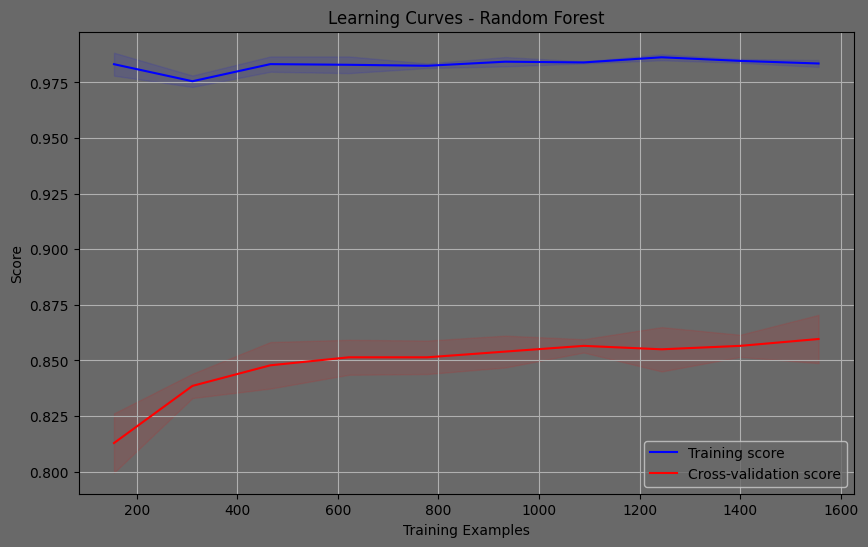

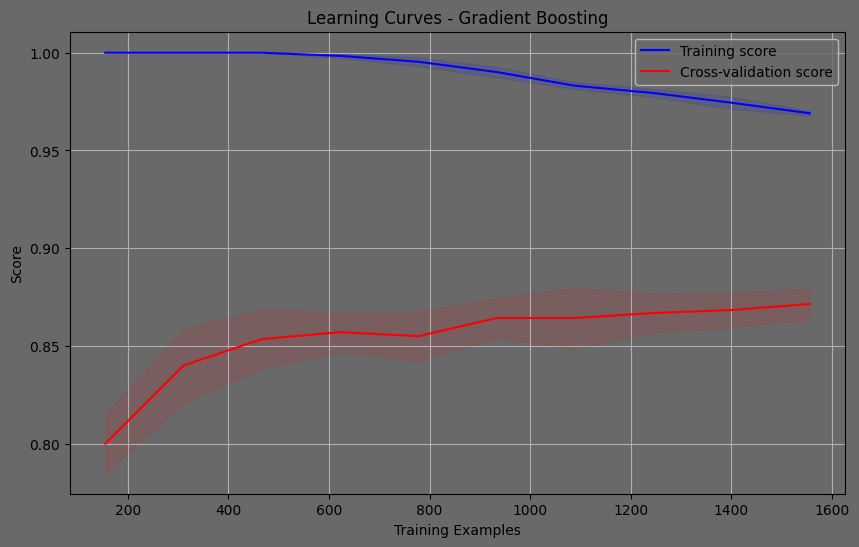

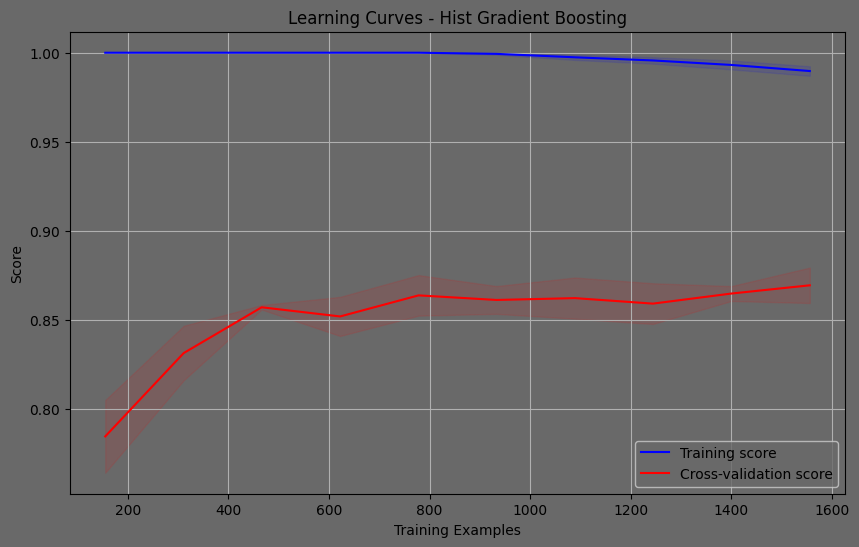

In [818]:
def plot_learning_curves(model, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5,
        n_jobs=-1,
        scoring='accuracy'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.plot(train_sizes, val_mean, label='Cross-validation score', color='red')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
    
    plt.title(f'Learning Curves - {title}')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

for name, result in results.items():
    plot_learning_curves(result['best_model'], X_train_selected, y_train, name)

The model selected as the final model wil be the Gradient Boosting model. It offers the highest cross-validation score and accuracy. It is also the model that shows the least over fitting. A draw back is that the training score is beginning to dip signalling that this model may have a lower ceiling for success when working with larger amounts of training data.

## 5. Conclusion

- Analyze feature importance to understand which features most strongly influence the prediction
- Explain how each top feature might contribute to the prediction

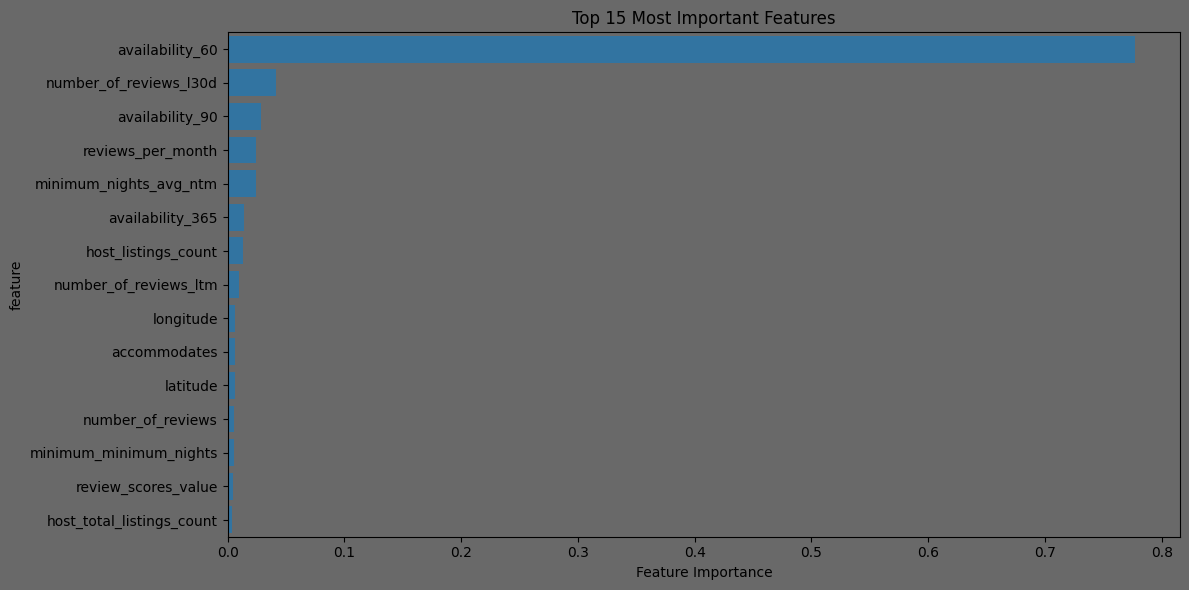

In [819]:
gb_model = results['Gradient Boosting']['best_model']
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': gb_model.feature_importances_
})

feature_importance = feature_importance.sort_values('importance', ascending=False)
top_features = feature_importance.head(15)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_features, x='importance', y='feature')
plt.title('Top 15 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

In [820]:
print("\nTop Feature Analysis:")
for _, row in top_features.iterrows():
    print(f"\n{row['feature']}: {row['importance']:.4f}")
    


Top Feature Analysis:

availability_60: 0.7769

number_of_reviews_l30d: 0.0417

availability_90: 0.0290

reviews_per_month: 0.0243

minimum_nights_avg_ntm: 0.0243

availability_365: 0.0139

host_listings_count: 0.0129

number_of_reviews_ltm: 0.0101

longitude: 0.0066

accommodates: 0.0064

latitude: 0.0060

number_of_reviews: 0.0058

minimum_minimum_nights: 0.0051

review_scores_value: 0.0043

host_total_listings_count: 0.0041


Surprisingly this model is predicting mostly off of one feature.

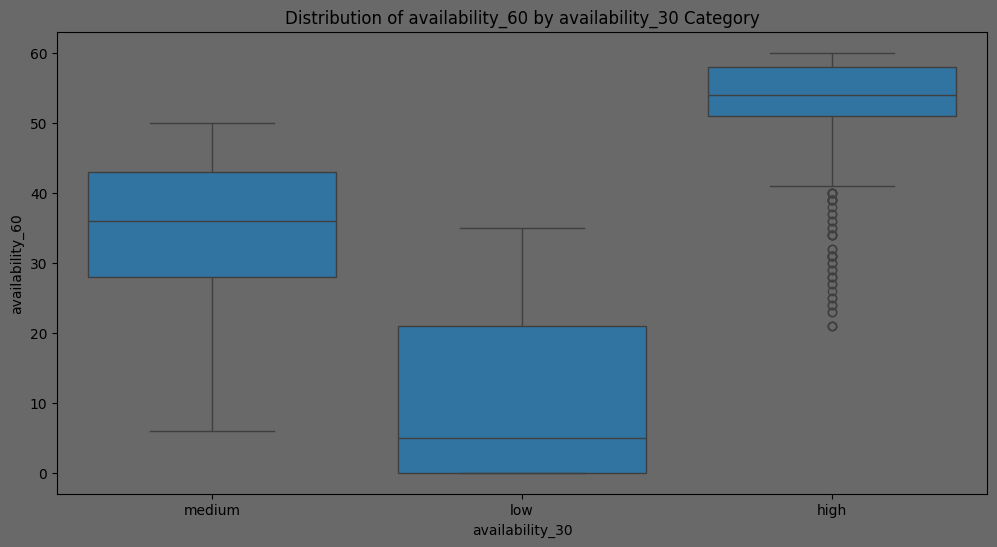


Summary statistics of availability_60 by availability_30 category:
                  count       mean        std   min   25%   50%   75%   max
availability_30                                                            
high              642.0  52.573209   7.686228  21.0  51.0  54.0  58.0  60.0
low               749.0  10.228304  11.228899   0.0   0.0   5.0  21.0  35.0
medium           1041.0  34.663785  10.242461   6.0  28.0  36.0  43.0  50.0


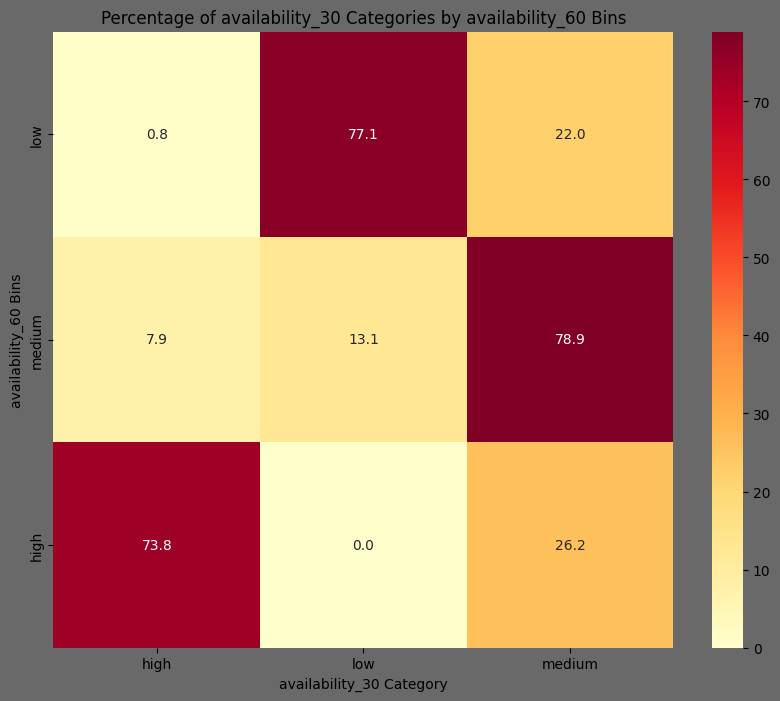

In [822]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='availability_30', y='availability_60')
plt.title('Distribution of availability_60 by availability_30 Category')
plt.show()

print("\nSummary statistics of availability_60 by availability_30 category:")
print(df.groupby('availability_30')['availability_60'].describe())

availability_bins = pd.qcut(df['availability_60'], q=3, labels=['low', 'medium', 'high'])
confusion_df = pd.crosstab(
    availability_bins, 
    df['availability_30'], 
    normalize='index'
) * 100

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, fmt='.1f', cmap='YlOrRd')
plt.title('Percentage of availability_30 Categories by availability_60 Bins')
plt.ylabel('availability_60 Bins')
plt.xlabel('availability_30 Category')
plt.show()

1. Key Predictive Features:
   - availability_60
   - This was the most predictive feature by far with an importance of .78. Looking at the distribution and heat map, which ever availability a listing has at 60 days it often has in 30 days as well.